In [1]:
repo_id = "LEAP/ClimSim_high-res"
local_dir = "./high_res_data/"

In [ ]:
import dataclasses
import functools
import shutil
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
from typing import Any
from huggingface_hub import hf_hub_download
from climsim.climsim_utils.data_utils import *
import fnmatch
from etils import etree
import time
import gc
import rich

from google.cloud import storage

In [3]:

# # Works for z_norm, not  keras norm

# s_values = pd.read_csv("S_values_norm.csv", index_col=0)
# s_mean = s_values.mean().values
# s_std = s_values.std().values

In [4]:
# np.save("s_mean.npy", s_mean)
# np.save("s_std.npy", s_std)

In [5]:
s_mean = np.load("s_mean.npy")
s_std = np.load("s_std.npy")

In [6]:
file_paths = [
    "climsim/climsim_high_res_train/high_res_data/train/0001-02/E3SM-MMF.mlo.0001-02-01-01200.nc",
    "climsim/climsim_high_res_train/high_res_data/train/0001-02/E3SM-MMF.mlo.0001-02-01-00000.nc",
    "climsim/climsim_high_res_train/high_res_data/train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc",
]


In [7]:
data_path = "climsim/climsim_high_res_train/high_res_data"
grid_path = os.path.join(data_path, "ClimSim_high-res_grid-info.nc")
norm_path = "climsim/preprocessing/normalizations/"
grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + "inputs/input_mean.nc")
input_max = xr.open_dataset(norm_path + "inputs/input_max.nc")
input_min = xr.open_dataset(norm_path + "inputs/input_min.nc")
output_scale = xr.open_dataset(norm_path + "outputs/output_scale.nc")

In [8]:
data = data_utils(
    grid_info=grid_info,
    input_mean=input_mean,
    input_max=input_max,
    input_min=input_min,
    output_scale=output_scale,
    )

In [9]:
data.set_to_v2_vars()

In [10]:
train_col_names = np.load('train_col_names.npy').tolist()

In [11]:
data.normalize = False
data.data_path = f"{data_path}/*/"

data.set_regexps(
    data_split="train",
    regexps=[
        "E3SM-MMF.mli.000[1234567]-*-*-*.nc",  # years 1 through 7
        "E3SM-MMF.mli.0008-01-*-*.nc",  # first month of year 8
    ],
)
data.set_stride_sample(data_split="train", stride_sample=1)
data.set_filelist(data_split="train")

In [12]:
data_loader = data.load_ncdata_with_generator(data_split="train")

2024-07-07 04:33:43.968498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 04:33:44.006334: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# file_ids = [f.split("/")[-1].split(".")[-2] for f in data.train_filelist]

# train_index = [
#     [f"train_{file_ids[f_idx]}_" + str(x) for x in range(len(npy_iterator[f_idx][0]))]
#     for f_idx in range(len(file_ids))
# ]
# train_index[0][:10]

In [20]:
train_index = np.array([npy_iterator[x][2] for x in range(len(npy_iterator))]).flatten()

In [18]:
train_index

[b'climsim/climsim_high_res_train/high_res_data/train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc']

In [27]:
npy_iterator = list(data_loader.as_numpy_iterator())
npy_input = np.concatenate([npy_iterator[x][0] for x in range(len(npy_iterator))])
print("dropping cam_in_SNOWHICE because of strange values")
drop_idx = train_col_names.index("cam_in_SNOWHICE")
npy_input = np.delete(npy_input, drop_idx, axis=1)

npy_output = np.concatenate([npy_iterator[x][1] for x in range(len(npy_iterator))])
filelist = np.array([npy_iterator[x][2] for x in range(len(npy_iterator))]).flatten()
filelist = [x.decode() for x in filelist]
file_ids = [f.split("/")[-1].split(".")[-2] for f in filelist]

train_index = [
    [f"train_{file_ids[f_idx]}_{str(x)}" for x in range(len(npy_iterator[f_idx][0]))]
    for f_idx in range(len(file_ids))
]
train_index = np.concatenate(train_index)
train_index

dropping cam_in_SNOWHICE because of strange values


2024-07-07 04:37:47.578120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array(['train_0001-02-01-00000_0', 'train_0001-02-01-00000_1',
       'train_0001-02-01-00000_2', ..., 'train_0001-02-01-00000_21597',
       'train_0001-02-01-00000_21598', 'train_0001-02-01-00000_21599'],
      dtype='<U28')

In [25]:
# Decode the train_index
train_index = [x.decode() for x in train_index]
train_index

['climsim/climsim_high_res_train/high_res_data/train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc']

In [171]:
npy_iterator = list(data_loader.as_numpy_iterator())

file_ids = [f.split("/")[-1].split(".")[-2] for f in data.train_filelist]

train_index = [
    [f"train_{file_ids[f_idx]}_{str(x)}" for x in range(len(npy_iterator[f_idx][0]))]
    for f_idx in range(len(file_ids))
]
train_index = np.concatenate(train_index)

npy_input = np.concatenate([npy_iterator[x][0] for x in range(len(npy_iterator))])
print("dropping cam_in_SNOWHICE because of strange values")
drop_idx = train_col_names.index("cam_in_SNOWHICE")
npy_input = np.delete(npy_input, drop_idx, axis=1)

npy_output = np.concatenate([npy_iterator[x][1] for x in range(len(npy_iterator))])


2024-07-05 20:27:55.566163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [172]:

train_npy = np.concatenate([npy_input, npy_output], axis=1)
df = pd.DataFrame(train_npy, index=train_index, columns=train_col_names)
df.index.name = "sample_id"
print("dropping cam_in_SNOWHICE because of strange values")
df.drop("cam_in_SNOWHICE", axis=1, inplace=True) 


dropping cam_in_SNOWHICE because of strange values


In [175]:

npy_input.shape

(21600, 556)

In [176]:
x = df.iloc[:, :556].values
(x == npy_input).all()

True

In [173]:
df.head()

,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
sample_id,,,,,,,,,,,,,,,,,,,,,
train_0001-02-01-00000_0,207.055270,211.916475,228.535400,246.777902,257.126849,264.007713,262.798149,254.549226,243.573396,236.751014,...,-1.509224e-06,0.000013,0.0,371.585815,0.0,4.917821e-11,0.0,0.0,0.0,0.0
train_0001-02-01-00000_1,206.855326,211.652274,227.318774,245.235531,256.645142,263.900101,262.722590,254.591878,243.686275,236.978755,...,7.817020e-06,0.000026,0.0,355.592114,0.0,2.393854e-08,0.0,0.0,0.0,0.0
train_0001-02-01-00000_2,208.059552,211.788561,230.287398,248.918899,257.806991,263.965864,263.001624,254.228763,243.240554,236.691815,...,6.712710e-08,0.000013,0.0,366.897439,0.0,8.468141e-09,0.0,0.0,0.0,0.0
train_0001-02-01-00000_3,207.650621,210.278647,229.484402,248.153931,258.238713,263.580540,262.819792,254.444710,243.401688,236.877773,...,-5.568698e-07,0.000012,0.0,353.468512,0.0,6.432240e-09,0.0,0.0,0.0,0.0
train_0001-02-01-00000_4,206.472879,212.369179,224.788810,243.777489,256.437026,264.038086,262.568779,254.461041,243.687937,237.271219,...,-3.482482e-06,0.000016,0.0,354.951936,0.0,9.966274e-09,0.0,0.0,0.0,0.0


In [12]:
ip_means = np.load("input_means.npy")
ip_stds = np.load("input_stds.npy")

train_mean_and_std_df = pd.read_csv("train_mean_and_std.csv", index_col=0)
op_means = train_mean_and_std_df["mean"][556:].values
op_stds = train_mean_and_std_df["std"][556:].values

def z_norm_input(x):
    # For full data -> (556,) only
    x_mean = x - ip_means
    x_norm = x_mean / ip_stds
    x_norm = tf.where(ip_stds < 1e-10, x_mean, x_norm)
    return x_norm

def z_denorm_input(x):
    # For full data -> (556,) only
    x_denorm = np.where(ip_stds < 1e-10, x + ip_means, x * ip_stds + ip_means)
    return x_denorm

def z_norm_output(y):
    # For full data -> (368,) only
    y_mean = y - op_means
    y_norm = y_mean / op_stds
    y_norm = tf.where(op_stds < 1e-10, y_mean, y_norm)
    return y_norm

def z_denorm_output(y):
    # For full data -> (368,) only
    y_denorm = np.where(op_stds < 1e-10, y + op_means, y * op_stds + op_means)
    return y_denorm

keras_mean_x = np.load("keras_mean_x.npy")[0]
keras_var_x = np.load("keras_var_x.npy")[0]
keras_std_x = np.maximum(1e-20, keras_var_x ** 0.5)

keras_mean_y = np.load("keras_mean_y.npy")[0]
keras_var_y = np.load("keras_var_y.npy")[0]
keras_std_y = keras_var_y ** 0.5
keras_std_y = keras_std_y.astype(np.float32)
keras_std_y = np.where(keras_std_y < 1e-33, 0, keras_std_y)


def keras_norm_input(x):
    x = (x - keras_mean_x) / keras_std_x
    return x

def keras_denorm_input(x):
    x = x * keras_std_x + keras_mean_x
    return x

def keras_norm_output(y):
    y_norm = (y - keras_mean_y) / keras_std_y
    y = np.where(keras_std_y == 0, y, y_norm)
    return y

def keras_denorm_output(y):
    y_denorm = y * keras_std_y + keras_mean_y
    y = np.where(keras_std_y == 0, y, y_denorm)
    return y

def calc_s_score(x):
    return np.sqrt(np.sum(x ** 2, axis=1))

In [13]:
chunk = df
chunk.head()

x = chunk.iloc[:, :556].values
y = chunk.iloc[:, 556:].values

x_norm = z_norm_input(x)
y_norm = z_norm_output(y)

Sx = calc_s_score(x_norm)
Sy = calc_s_score(y_norm)

Sx, Sy

/tmp/ipykernel_5831/3489656707.py:23: RuntimeWarning: invalid value encountered in divide
  y_norm = y_mean / op_stds


(array([15.71812807, 15.9208154 , 17.68045041, ..., 40.77169302,
        44.23259787, 39.22156787]),
 array([ 9.87021943, 12.87026864, 12.81308068, ..., 50.24784345,
        59.60099101, 34.3390548 ]))

In [14]:
Sx_norm = (Sx - s_mean) / s_std
Sx_norm.mean(), Sx_norm.std()

(0.3362942651397603, 1.2418147231726113)

In [15]:
Sx_norm[0]

-0.8308604412180541

In [16]:
bucket_size = 0.05
buckets = np.arange(-1.25, 4 + bucket_size, bucket_size)
buckets[44]

0.950000000000002

In [188]:
len(buckets)

106

In [17]:
# Distribute Sx_norm into buckets
Sx_norm_bucket = np.digitize(Sx_norm, buckets)
Sx_norm_bucket

array([ 9,  9, 14, ..., 74, 84, 70])

In [189]:
len(np.unique(Sx_norm_bucket, return_counts=True)[1])

105

In [207]:
bucket_indices = [np.where(Sx_norm_bucket == i)[0] for i in range(0, len(buckets)-1)]
len([len(x) for x in bucket_indices])

105

In [205]:
# Get the indices of the samples in each bucket
bucket_indices = [np.where(Sx_norm_bucket == i)[0] for i in range(0, len(buckets)-1)]
num_samples_in_each_bucket = dict(zip(range(len(buckets)-1), [len(x) for x in bucket_indices]))

In [206]:
num_samples_in_each_bucket

{0: 35,
 1: 19,
 2: 69,
 3: 95,
 4: 200,
 5: 219,
 6: 265,
 7: 315,
 8: 426,
 9: 441,
 10: 557,
 11: 629,
 12: 677,
 13: 688,
 14: 739,
 15: 654,
 16: 613,
 17: 601,
 18: 633,
 19: 558,
 20: 488,
 21: 528,
 22: 532,
 23: 503,
 24: 424,
 25: 430,
 26: 406,
 27: 329,
 28: 309,
 29: 305,
 30: 254,
 31: 248,
 32: 236,
 33: 219,
 34: 236,
 35: 237,
 36: 209,
 37: 220,
 38: 238,
 39: 204,
 40: 213,
 41: 203,
 42: 226,
 43: 228,
 44: 215,
 45: 223,
 46: 217,
 47: 219,
 48: 184,
 49: 220,
 50: 214,
 51: 223,
 52: 197,
 53: 208,
 54: 178,
 55: 183,
 56: 147,
 57: 153,
 58: 140,
 59: 154,
 60: 121,
 61: 123,
 62: 130,
 63: 107,
 64: 102,
 65: 109,
 66: 101,
 67: 75,
 68: 79,
 69: 84,
 70: 65,
 71: 77,
 72: 63,
 73: 62,
 74: 54,
 75: 68,
 76: 36,
 77: 54,
 78: 40,
 79: 52,
 80: 42,
 81: 48,
 82: 37,
 83: 38,
 84: 41,
 85: 34,
 86: 40,
 87: 38,
 88: 30,
 89: 34,
 90: 43,
 91: 27,
 92: 30,
 93: 31,
 94: 16,
 95: 19,
 96: 25,
 97: 20,
 98: 17,
 99: 15,
 100: 24,
 101: 14,
 102: 27,
 103: 20,
 104: 3

[35,
 19,
 69,
 95,
 200,
 219,
 265,
 315,
 426,
 441,
 557,
 629,
 677,
 688,
 739,
 654,
 613,
 601,
 633,
 558,
 488,
 528,
 532,
 503,
 424,
 430,
 406,
 329,
 309,
 305,
 254,
 248,
 236,
 219,
 236,
 237,
 209,
 220,
 238,
 204,
 213,
 203,
 226,
 228,
 215,
 223,
 217,
 219,
 184,
 220,
 214,
 223,
 197,
 208,
 178,
 183,
 147,
 153,
 140,
 154,
 121,
 123,
 130,
 107,
 102,
 109,
 101,
 75,
 79,
 84,
 65,
 77,
 63,
 62,
 54,
 68,
 36,
 54,
 40,
 52,
 42,
 48,
 37,
 38,
 41,
 34,
 40,
 38,
 30,
 34,
 43,
 27,
 30,
 31,
 16,
 19,
 25,
 20,
 17,
 15,
 24,
 14,
 27,
 20,
 355,
 0,
 0]

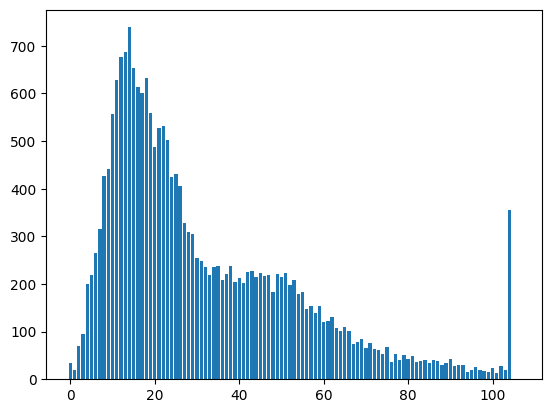

In [198]:
# plot number of samples in each bucket to see distribution
import matplotlib.pyplot as plt
plt.bar(range(len(buckets)-1), [len(x) for x in bucket_indices])
plt.show()

In [199]:
sample_weights_per_bucket = np.array([1 / num_samples_in_each_bucket[i] for i in range(len(buckets)-1)])
sample_weights_per_bucket

ZeroDivisionError: division by zero

In [94]:
sampling_probs_per_bucket = sample_weights_per_bucket / sample_weights_per_bucket.sum()
sampling_probs_per_bucket

array([0.01873721, 0.03451591, 0.00950438, 0.00690318, 0.00327901,
       0.00299453, 0.00247473, 0.00208191, 0.00153944, 0.00148708,
       0.00117738, 0.00104261, 0.00096869, 0.0009532 , 0.00088742,
       0.00100276, 0.00106982, 0.00109119, 0.00103602, 0.00117527,
       0.00134386, 0.00124205, 0.00123271, 0.00130378, 0.0015467 ,
       0.00152512, 0.00161528, 0.00199332, 0.00212234, 0.00215017,
       0.0025819 , 0.00264436, 0.00277882, 0.00299453, 0.00277882,
       0.0027671 , 0.00313781, 0.00298092, 0.00275547, 0.00321472,
       0.00307888, 0.00323055, 0.00290178, 0.00287633, 0.00305024,
       0.00294082, 0.00302213, 0.00299453, 0.00356414, 0.00298092,
       0.0030645 , 0.00294082, 0.00332895, 0.0031529 , 0.00368428,
       0.00358362, 0.00446124, 0.00428629, 0.0046843 , 0.00425846,
       0.00541985, 0.00533173, 0.00504463, 0.00612899, 0.00642943,
       0.00601653, 0.00649309, 0.00874403, 0.00830129, 0.00780717,
       0.01008927, 0.00851691, 0.01040956, 0.01057746, 0.01214

In [184]:
np.save("sampling_probs_per_bucket.npy", sampling_probs_per_bucket)

In [95]:
# Assign sample weights to each sample
# Sx_norm_bucket = np.clip(Sx_norm_bucket, 0, len(buckets)-2)
sample_weights = sample_weights_per_bucket[Sx_norm_bucket]

In [96]:
features = tfds.features.FeaturesDict(
    {
        "sample_id": tfds.features.Text(),
        "inputs": tfds.features.Tensor(shape=(556,), dtype=np.float32),
        "targets": tfds.features.Tensor(shape=(368,), dtype=np.float32),
        "sample_weight": tfds.features.Tensor(shape=(), dtype=np.float32),
    }
)

In [97]:
sample_ids = chunk.index.values
sample_ids

array(['train_0', 'train_1', 'train_2', ..., 'train_21597', 'train_21598',
       'train_21599'], dtype=object)

In [98]:
sample_weights_buckets = [sample_weights[i] for i in bucket_indices]
sample_weights_buckets

[array([0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143]),
 array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
        0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
        0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
        0.05263158, 0.05263158, 0.05263158, 0.05263158]),
 array([0.01449275, 0.01449275, 0.01449275, 0.01449275, 0.01449275,
        0.01449275, 0.01449275, 0.01449275, 0.01449275, 0.01449275,
        0.01449275, 0.01449275, 0.01449275, 0.01449275, 0.01449275,
        0.01449275, 0.01449275, 0.01449275, 0.01449275, 

In [26]:
import math

LOCAL_IDX = 0

tfrecords_dir = "climsim/climsim_high_res_train/1.0.0/"

DATASET = "climsim_high_res_train"
ALL_BUCKET_SPLIT_NAMES = [f"bucket_{i:03d}" for i in range(len(buckets) - 1)]
FILEFORMAT = "tfrecord"

# Split X and Y into buckets using bucket_indices
sample_id_buckets = [sample_ids[i] for i in bucket_indices]
x_buckets = [x[i] for i in bucket_indices]
y_buckets = [y[i] for i in bucket_indices]
sample_weights_buckets = [sample_weights[i] for i in bucket_indices]

LOCAL_SAMPLES_IN_BUCKET = {bucket_name: 0 for bucket_name in ALL_BUCKET_SPLIT_NAMES}

for i, SPLIT_NAME in enumerate(ALL_BUCKET_SPLIT_NAMES):

    split_sid = sample_id_buckets[i]
    split_x = x_buckets[i]
    split_y = y_buckets[i]
    split_sw = sample_weights_buckets[i]

    split_count = len(split_sid)
    max_examples_per_tfrecord = 250
    n_tfrecords = math.ceil(split_count / max_examples_per_tfrecord)
    LOCAL_SAMPLES_IN_BUCKET[SPLIT_NAME] = split_count

    _shuffler = tfds.core.shuffle.Shuffler(
        dirpath=tfrecords_dir,
        hash_salt=str(LOCAL_IDX),
    )

    for j in range(n_tfrecords):

        start_idx = j * max_examples_per_tfrecord
        end_idx = (j + 1) * max_examples_per_tfrecord

        if end_idx > split_count:
            end_idx = split_count

        # TODO: switch types to float32 at the very top
        
        x_chunk = split_x[start_idx:end_idx].astype(np.float32)
        y_chunk = split_y[start_idx:end_idx].astype(np.float32)
        sw_chunk = split_sw[start_idx:end_idx].astype(np.float32)
        sid_chunk = split_sid[start_idx:end_idx]

        with tf.io.TFRecordWriter(
            f"{tfrecords_dir}/{DATASET}-{SPLIT_NAME}.{FILEFORMAT}-{j:05d}-incomplete_{LOCAL_IDX}"
        ) as writer:
            for sid, eg_x, eg_y, sw in zip(sid_chunk, x_chunk, y_chunk, sw_chunk):
                data = {
                    "sample_id": sid,
                    "inputs": eg_x,
                    "targets": eg_y,
                    "sample_weight": sw,
                }
                data_bytes = features.serialize_example(data)
                writer.write(data_bytes)

In [102]:
tfrecords_dir = "climsim/climsim_high_res_train/1.0.0/"

DATASET = "climsim_high_res_train"
ALL_BUCKET_SPLIT_NAMES = [f"bucket_{i:03d}" for i in range(len(buckets) - 1)]
FILEFORMAT = "tfrecord"
LOCAL_SAMPLES_IN_BUCKET = {bucket_name: 0 for bucket_name in ALL_BUCKET_SPLIT_NAMES}

In [103]:
class ExampleWriter:
    """Writes examples to files."""

    def __init__(self):
        self.file_format = tfds.core.file_adapters.FileFormat.TFRECORD

    def write(self, path, examples):
        """Write examples from iterator."""
        adapter = tfds.core.file_adapters.ADAPTER_FOR_FORMAT[self.file_format]
        return adapter.write_examples(path, examples)


example_writer = ExampleWriter()

# TEST ExampleWriter
# def iter_data():
#     for sid, eg_x, eg_y, sw in zip(sid_chunk, x_chunk, y_chunk, sw_chunk):
#         data = {
#             "sample_id": sid,
#             "inputs": eg_x,
#             "targets": eg_y,
#             "sample_weight": sw,
#         }
#         data_bytes = features.serialize_example(data)
#         yield sid, data_bytes

# example_writer.write(f"{tfrecords_dir}/{DATASET}-{SPLIT_NAME}.{FILEFORMAT}-incomplete_test", iter_data())

In [104]:
from __future__ import annotations

from collections.abc import Iterable, Sequence
import dataclasses
import functools
import itertools
import json
import os
from typing import Any

from etils import epy
from tensorflow_datasets.core.utils.lazy_imports_utils import apache_beam as beam

from etils import epy

with epy.lazy_imports():
  # pylint: disable=g-import-not-at-top
  from absl import logging
  from etils import epath
  from tensorflow_datasets.core import example_parser
  from tensorflow_datasets.core import example_serializer
  from tensorflow_datasets.core import file_adapters
  from tensorflow_datasets.core import hashing
  from tensorflow_datasets.core import naming
  from tensorflow_datasets.core import shuffle
  from tensorflow_datasets.core import utils
  from tensorflow_datasets.core.utils import file_utils
  from tensorflow_datasets.core.utils import shard_utils
  from tensorflow_datasets.core.utils import type_utils

In [105]:
_INDEX_PATH_SUFFIX = "_index.json"


@dataclasses.dataclass(frozen=True)
class _ShardSpec:
  """Spec to write a final records shard.

  Attributes:
    shard_index: Index of the shard.
    path: The path where to write the shard.
    index_path: The path where to write index of the records in the
      corresponding shard. NOTE: Value for this attribute is always set, but
      usage depends on whether `write_examples` returned a list of record
      positions for each example.
    examples_number: Number of examples in shard.
    file_instructions: Reading instructions.
  """

  shard_index: int
  path: str
  index_path: str
  examples_number: int
  file_instructions: Sequence[shard_utils.FileInstruction]


def _raise_error_for_duplicated_keys(example1, example2, example_specs):
  """Log information about the examples and raise an AssertionError."""
  msg = "Two examples share the same hashed key!"
  logging.error(msg)
  try:
    parser = example_parser.ExampleParser(example_specs)
    ex1 = parser.parse_example(example1)
    ex2 = parser.parse_example(example2)
    logging.error("1st example: %s", ex1)
    logging.error("2nd example: %s", ex2)
  except ValueError:
    logging.error(
        "Failed to parse examples! Cannot log them to see the examples behind"
        " the duplicated keys. Raw example 1: %s, raw example 2: %s",
        example1,
        example2,
    )
  raise AssertionError(msg + " See logs above to view the examples.")


def _get_index_path(path: str) -> epath.PathLike:
  """Returns path to the index file of the records stored at the given path.

  E.g: Say the path to a shard of records (of a particular split) are stored at
  `your/path/to/records/foo.riegeli-00001-of-00005`, it is transformed into
  `your/path/to/records/foo.riegeli-00001-of-00005_index.json`.

  Args:
    path: Path to the record file.

  Returns:
    Path of the index file of a shard of records stored at given path.
  """
  return path + _INDEX_PATH_SUFFIX


def _get_shard_specs(
    num_examples: int,
    total_size: int,
    bucket_lengths: Sequence[int],
    filename_template: naming.ShardedFileTemplate,
    shard_config: shard_utils.ShardConfig,
) -> Sequence[_ShardSpec]:
  """Returns list of _ShardSpec instances, corresponding to shards to write.

  Args:
    num_examples: int, number of examples in split.
    total_size: int (bytes), sum of example sizes.
    bucket_lengths: list of ints, number of examples in each bucket.
    filename_template: template to format sharded filenames.
    shard_config: the configuration for creating shards.
  """
  num_shards = shard_config.get_number_shards(total_size, num_examples)
  shard_boundaries = shard_utils.get_shard_boundaries(num_examples, num_shards)
  shard_specs = []
  bucket_indexes = [str(i) for i in range(len(bucket_lengths))]
  from_ = 0
  for shard_index, to in enumerate(shard_boundaries):
    # Read the bucket indexes
    file_instructions = shard_utils.get_file_instructions(
        from_, to, bucket_indexes, bucket_lengths
    )
    shard_path = filename_template.sharded_filepath(
        shard_index=shard_index, num_shards=num_shards
    )
    index_path = _get_index_path(os.fspath(shard_path))
    shard_specs.append(
        _ShardSpec(
            shard_index=shard_index,
            path=os.fspath(shard_path),
            index_path=index_path,
            examples_number=to - from_,
            file_instructions=file_instructions,
        )
    )
    from_ = to
  return shard_specs


def _write_index_file(
    sharded_index_path: epath.PathLike, record_keys: Sequence[Any]
):
  """Writes index file for records of a shard at given `sharded_index_path`.

  NOTE: Each record position (i.e shard_key in shard_keys) is stored as a
  string for better readability of the index files. The reader should parse the
  position from string using `RecordPosition.from_str()` method.

  Args:
    sharded_index_path: Path to the sharded index path.
    record_keys: Sequence of keys/indices of the records in the shard.
  """
  # Store string representation of each record position.
  #
  # NOTE: This makes the index file more readable. Although the reader should
  # parse the record position from a string.
  index_info = {"index": [str(record_key) for record_key in record_keys]}
  epath.Path(sharded_index_path).write_text(json.dumps(index_info))
  logging.info("Wrote index file to %s", os.fspath(sharded_index_path))

In [106]:
class Writer:
    """Shuffles and writes Examples to sharded files.

    The number of shards is computed automatically.
    """

    def __init__(
        self,
        filename_template: naming.ShardedFileTemplate,
        hash_salt,
        disable_shuffling: bool,
        example_writer: ExampleWriter,
        shard_config: shard_utils.ShardConfig | None = None,
        ignore_duplicates: bool = False,
    ):
        """Initializes Writer.

        Args:
          serializer: class that can serialize examples.
          filename_template: template to format sharded filenames.
          hash_salt (str or bytes): salt to hash keys.
          disable_shuffling (bool): Specifies whether to shuffle the records.
          example_writer: class that writes examples to disk or elsewhere.
          shard_config: the configuration for creating shards.
          ignore_duplicates: whether to ignore duplicated examples with the same
            key. If False, a `DuplicatedKeysError` will be raised on duplicates.
        """
        self._serializer = features
        self._shuffler = shuffle.Shuffler(
            dirpath=filename_template.data_dir,
            hash_salt=hash_salt,
        )
        self._filename_template = filename_template
        self._shard_config = shard_config or shard_utils.ShardConfig()
        self._example_writer = example_writer

    def write(self, key: int | bytes, serialized_example):
        """Writes given example.

        The given example is not directly written to the shard, but to a
        temporary file (or memory). The finalize() method writes all the shards.

        Args:
          key (int|bytes): the key associated with the example. Used for shuffling.
          example: the Example to write to the shard.
        """
        # serialized_example = self._serializer.serialize_example(example)
        self._shuffler.add(key, serialized_example)

    def finalize(self) -> tuple[list[int], int]:
        """Effectively writes examples to the shards."""
        if self._shuffler.num_examples == 0:
            raise AssertionError("No examples were yielded.")

        shard_specs = _get_shard_specs(
            num_examples=self._shuffler.num_examples,
            total_size=self._shuffler.size,
            bucket_lengths=self._shuffler.bucket_lengths,
            filename_template=self._filename_template,
            shard_config=self._shard_config,
        )
        filename = self._filename_template.sharded_filepaths_pattern()
        # Here we just loop over the examples, and don't use the instructions, just
        # the final number of examples in every shard. Instructions could be used to
        # parallelize, but one would need to be careful not to sort buckets twice.
        examples_generator = iter(
            utils.tqdm(
                self._shuffler,
                desc=f"Shuffling {filename}...",
                total=self._shuffler.num_examples,
                unit=" examples",
                leave=False,
                mininterval=1.0,
            )
        )
        try:
            for shard_spec in shard_specs:
                iterator = itertools.islice(
                    examples_generator, 0, shard_spec.examples_number
                )
                record_keys = self._example_writer.write(shard_spec.path, iterator)

                # No shard keys returned (e.g: TFRecord format), index cannot be
                # created.
                if not record_keys:
                    continue

                # Number of `shard_keys` received should match the number of examples
                # written in this shard.
                if len(record_keys) != int(shard_spec.examples_number):
                    raise RuntimeError(
                        f"Length of example `keys` ({len(record_keys)}) does not match "
                        f"`shard_spec.examples_number: (`{shard_spec.examples_number})"
                    )
                _write_index_file(shard_spec.index_path, record_keys)

        except shuffle.DuplicatedKeysError as err:
            _raise_error_for_duplicated_keys(
                err.item1, err.item2, self._serializer.example_specs
            )

        # Finalize the iterator to clear-up TQDM
        try:
            val = next(examples_generator)
        except StopIteration:
            pass
        else:
            raise ValueError(
                f"Shuffling more elements than expected. Additional element: {val}"
            )

        shard_lengths = [int(spec.examples_number) for spec in shard_specs]

        logging.info(
            "Done writing %s. Number of examples: %s (shards: %s)",
            filename,
            sum(shard_lengths),
            shard_lengths,
        )
        return shard_lengths, self._shuffler.size

In [107]:
# Test Writer

# filename_template = tfds.core.ShardedFileTemplate(
#     data_dir=tfrecords_dir,
#     dataset_name=DATASET,
#     split=SPLIT_NAME,
#     filetype_suffix=FILEFORMAT,
# )

# example_writer = ExampleWriter()

# split_writer = Writer(
#     filename_template=filename_template,
#     hash_salt=str(LOCAL_IDX),
#     disable_shuffling=False,
#     example_writer=example_writer,
# )

# def write_split_data():
#     for sid, eg_x, eg_y, sw in zip(sid_chunk, x_chunk, y_chunk, sw_chunk):
#         data = {
#             "sample_id": sid,
#             "inputs": eg_x,
#             "targets": eg_y,
#             "sample_weight": sw,
#         }
#         data_bytes = features.serialize_example(data)
#         split_writer.write(sid, data_bytes)

# write_split_data()
# split_writer.finalize()

In [108]:
LOCAL_IDX = 0

# Split X and Y into buckets using bucket_indices
sample_id_buckets = [sample_ids[i] for i in bucket_indices]
x_buckets = [x[i] for i in bucket_indices]
y_buckets = [y[i] for i in bucket_indices]
sample_weights_buckets = [sample_weights[i] for i in bucket_indices]


for i, SPLIT_NAME in enumerate(ALL_BUCKET_SPLIT_NAMES):

    split_sid = sample_id_buckets[i]
    split_x = x_buckets[i].astype(np.float32)
    split_y = y_buckets[i].astype(np.float32)
    split_sw = sample_weights_buckets[i].astype(np.float32)
    LOCAL_SAMPLES_IN_BUCKET[SPLIT_NAME] = len(split_sid)

    filename_template = tfds.core.ShardedFileTemplate(
        data_dir=tfrecords_dir,
        dataset_name=DATASET,
        split=SPLIT_NAME,
        filetype_suffix=FILEFORMAT,
    )

    example_writer = ExampleWriter()

    split_writer = Writer(
        filename_template=filename_template,
        hash_salt=str(LOCAL_IDX),
        disable_shuffling=False,
        example_writer=example_writer,
    )

    def write_split_data():
        for sid, eg_x, eg_y, sw in zip(split_sid, split_x, split_y, split_sw):
            data = {
                "sample_id": sid,
                "inputs": eg_x,
                "targets": eg_y,
                "sample_weight": sw,
            }
            data_bytes = features.serialize_example(data)
            split_writer.write(sid, data_bytes)

    write_split_data()
    split_writer.finalize()


split_infos = tfds.folder_dataset.compute_split_info(
    filename_template=filename_template
)

tfds.folder_dataset.write_metadata(
    data_dir=tfrecords_dir,
    features=features,
    split_infos=split_infos,
    homepage="https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/data/",
    supervised_keys=("inputs", "targets"),
)

Auto-detected splits:
 * bucket_000: 1 shards
 * bucket_001: 1 shards
 * bucket_002: 1 shards
 * bucket_003: 1 shards
 * bucket_004: 1 shards
 * bucket_005: 1 shards
 * bucket_006: 1 shards
 * bucket_007: 1 shards
 * bucket_008: 1 shards
 * bucket_009: 1 shards
 * bucket_010: 1 shards
 * bucket_011: 1 shards
 * bucket_012: 1 shards
 * bucket_013: 1 shards
 * bucket_014: 1 shards
 * bucket_015: 1 shards
 * bucket_016: 1 shards
 * bucket_017: 1 shards
 * bucket_018: 1 shards
 * bucket_019: 1 shards
 * bucket_020: 1 shards
 * bucket_021: 1 shards
 * bucket_022: 1 shards
 * bucket_023: 1 shards
 * bucket_024: 1 shards
 * bucket_025: 1 shards
 * bucket_026: 1 shards
 * bucket_027: 1 shards
 * bucket_028: 1 shards
 * bucket_029: 1 shards
 * bucket_030: 1 shards
 * bucket_031: 1 shards
 * bucket_032: 1 shards
 * bucket_033: 1 shards
 * bucket_034: 1 shards
 * bucket_035: 1 shards
 * bucket_036: 1 shards
 * bucket_037: 1 shards
 * bucket_038: 1 shards
 * bucket_039: 1 shards
 * bucket_040: 1 s

  0%|          | 0/105 [00:00<?, ?it/s]2024-07-05 18:24:49.789072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-05 18:24:49.852319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  2%|▏         | 2/105 [00:00<00:06, 16.20it/s]2024-07-05 18:24:49.972972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-05 18:24:50.038339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  4%|▍         | 4/105 [00:00<00:08, 12.47it/s]2024-07-05 18:24:50.362142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-05 18:24:50.414779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is a

Computed split infos: 
[<SplitInfo num_examples=35, num_shards=1>,
 <SplitInfo num_examples=19, num_shards=1>,
 <SplitInfo num_examples=69, num_shards=1>,
 <SplitInfo num_examples=95, num_shards=1>,
 <SplitInfo num_examples=200, num_shards=1>,
 <SplitInfo num_examples=219, num_shards=1>,
 <SplitInfo num_examples=265, num_shards=1>,
 <SplitInfo num_examples=315, num_shards=1>,
 <SplitInfo num_examples=426, num_shards=1>,
 <SplitInfo num_examples=441, num_shards=1>,
 <SplitInfo num_examples=557, num_shards=1>,
 <SplitInfo num_examples=629, num_shards=1>,
 <SplitInfo num_examples=677, num_shards=1>,
 <SplitInfo num_examples=688, num_shards=1>,
 <SplitInfo num_examples=739, num_shards=1>,
 <SplitInfo num_examples=654, num_shards=1>,
 <SplitInfo num_examples=613, num_shards=1>,
 <SplitInfo num_examples=601, num_shards=1>,
 <SplitInfo num_examples=633, num_shards=1>,
 <SplitInfo num_examples=558, num_shards=1>,
 <SplitInfo num_examples=488, num_shards=1>,
 <SplitInfo num_examples=528, num_sh

2024-07-05 18:24:54.726717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [132]:
# Find out how many files are in the tfrecords directory

import glob
tfrecords_files = glob.glob(f"{tfrecords_dir}/*.tfrecord*")
len(tfrecords_files), tfrecords_files

(105,
 ['climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_000.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_001.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_002.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_003.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_004.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_005.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_006.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_007.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_008.tfrecord-00000-of-00001',
  'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_009.tfrecord-00000-of-00

In [133]:
total_examples = np.sum([s.num_examples for s in split_infos])
total_examples

21600

In [135]:
for f in tfrecords_files: os.remove(f)

FileNotFoundError: [Errno 2] No such file or directory: 'climsim/climsim_high_res_train/1.0.0/climsim_high_res_train-bucket_000.tfrecord-00000-of-00001'

In [115]:
# Y = len(tfrecords_files)
# DATASET = "climsim_high_res_train"
# SPLIT = "train"
# FILEFORMAT = "tfrecord"

# for i, file in enumerate(tfrecords_files):
#     new_filename = f"{tfrecords_dir}/{DATASET}-{SPLIT}.{FILEFORMAT}-{i:05d}-of-{Y:05d}"
#     os.rename(file, new_filename)

In [116]:
# split_infos = [
#     tfds.core.SplitInfo(
#         name='train',
#         shard_lengths=[21600,],  # Num of examples in shard0, shard1,...
#         num_bytes=0,  # Total size of your dataset (if unknown, set to 0)
#     ),
# ]

In [122]:
tfrecords_dir = "climsim/climsim_high_res_train/1.0.0/"

builder = tfds.builder_from_directory(tfrecords_dir)

splits = builder.info.splits
total_examples = sum([s.num_examples for s in splits.values()])
print(total_examples)


all_ds = builder.as_dataset()

sampling_probs_per_bucket = np.load("sampling_probs_per_bucket.npy")

train_ds = tf.data.Dataset.sample_from_datasets(
    datasets=all_ds.values(),
    weights=sampling_probs_per_bucket,
    seed=42,
    rerandomize_each_iteration=True,
)

21600
tf.Tensor(b'train_15802', shape=(), dtype=string)


2024-07-05 18:29:52.781456: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-05 18:29:52.791783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [131]:
sampling_probs_per_bucket / np.min(sampling_probs_per_bucket)

array([21.11428571, 38.89473684, 10.71014493,  7.77894737,  3.695     ,
        3.37442922,  2.78867925,  2.34603175,  1.73474178,  1.67573696,
        1.32675045,  1.17488076,  1.0915805 ,  1.07412791,  1.        ,
        1.12996942,  1.20554649,  1.2296173 ,  1.16745656,  1.32437276,
        1.51434426,  1.39962121,  1.38909774,  1.46918489,  1.74292453,
        1.71860465,  1.82019704,  2.24620061,  2.39158576,  2.42295082,
        2.90944882,  2.97983871,  3.13135593,  3.37442922,  3.13135593,
        3.11814346,  3.53588517,  3.35909091,  3.10504202,  3.62254902,
        3.46948357,  3.64039409,  3.2699115 ,  3.24122807,  3.4372093 ,
        3.31390135,  3.40552995,  3.37442922,  4.01630435,  3.35909091,
        3.45327103,  3.31390135,  3.75126904,  3.55288462,  4.15168539,
        4.03825137,  5.02721088,  4.83006536,  5.27857143,  4.7987013 ,
        6.10743802,  6.00813008,  5.68461538,  6.90654206,  7.24509804,
        6.77981651,  7.31683168,  9.85333333,  9.35443038,  8.79

In [127]:
for data in train_ds.take(1):
    sample_id_str_decoded = tf.strings.as_string(data["sample_id"])
    sample_id = sample_id_str_decoded.numpy().decode("utf-8")
    print(f"Sample ID: {sample_id}")

Sample ID: train_19803, Sample Weight: 0.06666667014360428
Sample ID: train_16135, Sample Weight: 0.05263157933950424
Sample ID: train_20115, Sample Weight: 0.03333333507180214
Sample ID: train_21160, Sample Weight: 0.03333333507180214
Sample ID: train_3129, Sample Weight: 0.05263157933950424
Sample ID: train_13786, Sample Weight: 0.02857142873108387
Sample ID: train_10091, Sample Weight: 0.05263157933950424
Sample ID: train_2366, Sample Weight: 0.0014771048445254564
Sample ID: train_19697, Sample Weight: 0.06666667014360428
Sample ID: train_7936, Sample Weight: 0.05000000074505806
Sample ID: train_19842, Sample Weight: 0.013333333656191826
Sample ID: train_16820, Sample Weight: 0.013333333656191826
Sample ID: train_4333, Sample Weight: 0.06666667014360428
Sample ID: train_329, Sample Weight: 0.010526316240429878
Sample ID: train_11154, Sample Weight: 0.05263157933950424
Sample ID: train_10090, Sample Weight: 0.05000000074505806
Sample ID: train_20946, Sample Weight: 0.0526315793395042

2024-07-05 18:33:43.579804: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-05 18:33:43.580381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-05 18:33:43.580917: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

In [ ]:
feature_description = {
    "sample_id": tf.io.FixedLenFeature([], tf.string),
    "inputs": tf.io.FixedLenFeature([556], tf.float32),
    "targets": tf.io.FixedLenFeature([368], tf.float32),
    "sample_weight": tf.io.FixedLenFeature([], tf.float32),
}


def read_tfrecord(serialized_example):
    example = tf.io.parse_single_example(
        serialized_example,
        feature_description,
    )
    return example


files = [
    f"{tfrecords_dir}/climsim_high_res_train-train.tfrecord-0000",
]

train_ds = tf.data.TFRecordDataset(files)
train_ds = train_ds.map(read_tfrecord)

In [ ]:
for data in train_ds.take(1):
    print(data)

{'inputs': <tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 2.07055267e+02,  2.11916473e+02,  2.28535400e+02,  2.46777908e+02,
        2.57126862e+02,  2.64007721e+02,  2.62798157e+02,  2.54549225e+02,
        2.43573395e+02,  2.36751007e+02,  2.31174316e+02,  2.26797668e+02,
        2.22784592e+02,  2.18919464e+02,  2.17121719e+02,  2.13479294e+02,
        2.09664444e+02,  2.06023132e+02,  2.04334518e+02,  2.08351257e+02,
        2.08797073e+02,  2.08813232e+02,  2.12524200e+02,  2.16916702e+02,
        2.20329056e+02,  2.23963196e+02,  2.28154724e+02,  2.32581726e+02,
        2.36802277e+02,  2.40904236e+02,  2.45169006e+02,  2.49373260e+02,
        2.53526993e+02,  2.57559875e+02,  2.61447754e+02,  2.65122162e+02,
        2.68394897e+02,  2.71069000e+02,  2.73187256e+02,  2.75279694e+02,
        2.76763885e+02,  2.78157288e+02,  2.79022003e+02,  2.80009064e+02,
        2.81227722e+02,  2.80480011e+02,  2.77163605e+02,  2.78573242e+02,
        2.79930298e+02,  2.81022949e+02, 

2024-07-05 01:29:27.873170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [209]:
import rich

with open("climsim/all_files_in_high_res.pkl", "rb") as f:
    all_file_paths = pickle.load(f)
all_file_paths = all_file_paths[::7]


input_files = [f for f in all_file_paths if "mli" in f]
output_files = set([f for f in all_file_paths if "mlo" in f])

regexps = [
        "*/*/E3SM-MMF.mli.000[1234567]-*-*-*.nc",  # years 1 through 7
        "*/*/E3SM-MMF.mli.0008-01-*-*.nc",  # first month of year 8
    ]

start = time.time()

matched_files = []
for pattern in regexps:
    matched_files.extend(fnmatch.filter(input_files, pattern))

print(f"Matching files took {time.time() - start} seconds")
start = time.time()

filtered_files = [
    ip_f for ip_f in matched_files if ip_f.replace("mli", "mlo") in output_files
]
print(f"Total filtered files: {len(filtered_files)}")
print(f"Filtering files took {time.time() - start} seconds")

filtered_files = np.array(filtered_files)

# np.random.seed(42)
# np.random.shuffle(filtered_files)

splits = np.array_split(filtered_files, 512)
splits = [s.tolist() for s in splits]

splits[0]

Matching files took 0.022415637969970703 seconds
Total filtered files: 2016
Filtering files took 0.004160404205322266 seconds


['train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-08400.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-16800.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-25200.nc']

In [179]:
split_writer._filename_template

ShardedFileTemplate(data_dir=PosixGPath('climsim/climsim_high_res_train/1.0.0'), template='{DATASET}-{SPLIT}.{FILEFORMAT}-{SHARD_X_OF_Y}', dataset_name='climsim_high_res_train', split='bucket_104', filetype_suffix='tfrecord')

In [212]:
len(matched_files), len(input_files), len(output_files)

(26280, 30034, 29336)

In [221]:
ip_f_to_op_f = np.array([ip_f.replace("mli", "mlo") for ip_f in input_files])
all_op_f = np.array([f for f in all_file_paths if "mlo" in f])

In [227]:
# Print not found files
not_found_files = np.setdiff1d(ip_f_to_op_f, all_op_f)
not_found_files
# np.intersect1d(ip_f_to_op_f, all_op_f)

array(['train/0001-03/E3SM-MMF.mlo.0001-03-01-00000.nc',
       'train/0001-03/E3SM-MMF.mlo.0001-03-01-08400.nc',
       'train/0001-03/E3SM-MMF.mlo.0001-03-01-16800.nc', ...,
       'train/0009-01/E3SM-MMF.mlo.0009-01-31-68400.nc',
       'train/0009-01/E3SM-MMF.mlo.0009-01-31-76800.nc',
       'train/0009-01/E3SM-MMF.mlo.0009-01-31-85200.nc'], dtype='<U46')

In [228]:
all_op_f

array(['train/0001-02/E3SM-MMF.mlo.0001-02-01-00000.nc',
       'train/0001-02/E3SM-MMF.mlo.0001-02-01-08400.nc',
       'train/0001-02/E3SM-MMF.mlo.0001-02-01-16800.nc', ...,
       'train/0009-01/E3SM-MMF.mlo.0009-01-05-73200.nc',
       'train/0009-01/E3SM-MMF.mlo.0009-01-05-81600.nc',
       'train/0009-01/E3SM-MMF.mlo.0009-01-06-03600.nc'], dtype='<U46')

In [239]:
n_splits = 512
with open("climsim/all_files_in_high_res.pkl", "rb") as f:
    all_file_paths = pickle.load(f)

input_files = [f for f in all_file_paths if "mli" in f]
output_files = set([f for f in all_file_paths if "mlo" in f])

print(f"Total input files: {len(input_files)}")
print(f"Total output files: {len(output_files)}")

regexps = [
    "*/*/E3SM-MMF.mli.000[1234567]-*-*-*.nc",  # years 1 through 7
    "*/*/E3SM-MMF.mli.0008-01-*-*.nc",  # first month of year 8
]

start = time.time()

matched_files = []
for pattern in regexps:
    matched_files.extend(fnmatch.filter(input_files, pattern))
    
print(f"Total matched files: {len(matched_files)}")
print(f"Matching files took {time.time() - start} seconds")
start = time.time()

filtered_files = [
    ip_f for ip_f in matched_files if ip_f.replace("mli", "mlo") in output_files
]
filtered_files = filtered_files[::7] # Time Stride
print(f"Total filtered files: {len(filtered_files)}")
print(f"Filtering files took {time.time() - start} seconds")

splits = np.array_split(np.array(filtered_files), n_splits)
splits = [s.tolist() for s in splits]

Total input files: 210240
Total output files: 205348
Total matched files: 183960
Matching files took 0.1481027603149414 seconds
Total filtered files: 26050
Filtering files took 0.04165816307067871 seconds


In [240]:
filtered_files

['train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-08400.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-16800.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-25200.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-33600.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-42000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-50400.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-58800.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-67200.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-75600.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-01-84000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-06000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-14400.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-22800.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-31200.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-39600.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-48000.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-56400.nc',
 'train/0001-02/E3SM-MMF.mli.0001-02-02-64800.nc',
 'train/0001-02/E3SM-MMF.mli.00

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

TFRECORDS_DIR_BASE = "gs://us2-climsim/climsim_high_res_train/"
VERSION = "1.0.0"

all_tfrecords_dir = [
    f"{TFRECORDS_DIR_BASE}/LOCAL_{idx}/{VERSION}/" for idx in range(64)
]

# TEMP remove LOCAL_33 
all_tfrecords_dir = [d for d in all_tfrecords_dir if "LOCAL_33" not in d]

builder = tfds.builder_from_directories(builder_dirs=all_tfrecords_dir)
splits = builder.info.splits

num_examples_per_bucket = {n : s.num_examples for n, s in splits.items()}
print(num_examples_per_bucket)

total_examples = sum(num_examples_per_bucket)
print(total_examples)

sample_weights_per_bucket = 1 / np.array(num_examples_per_bucket)
sampling_probs_per_bucket = (
    sample_weights_per_bucket / (sample_weights_per_bucket).sum()
)

all_ds = builder.as_dataset(shuffle_files=True)

train_ds = tf.data.Dataset.sample_from_datasets(
    datasets=all_ds.values(),
    weights=sampling_probs_per_bucket,
    seed=42,
    rerandomize_each_iteration=True,
)

shuffle_buffer_size = 10_000
print(f"Shuffling with buffer size {shuffle_buffer_size}")
train_ds = train_ds.shuffle(shuffle_buffer_size)
    
for data in train_ds.take(5):
    sample_id_str_decoded = tf.strings.as_string(data["sample_id"])
    sample_id = sample_id_str_decoded.numpy().decode("utf-8")
    print(f"Sample ID: {sample_id}")

2024-07-07 20:05:34.523027: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 20:05:37.437664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 20:05:44.283112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
split_keys = list(range(107))
all_local_split_keys = [split_keys[i::8] for i in range(8)]
all_local_split_keys[0]

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

TFRECORDS_DIR_BASE = "gs://us2-climsim/climsim_high_res_train/"
VERSION = "1.0.0"

all_tfrecords_dir = [
    f"{TFRECORDS_DIR_BASE}/LOCAL_{idx}/{VERSION}/" for idx in range(64)
]

builder = tfds.builder_from_directories(builder_dirs=all_tfrecords_dir)
splits = builder.info.splits

num_examples_per_bucket = {n : s.num_examples for n, s in splits.items()}
print(num_examples_per_bucket)

2024-07-09 11:04:11.097392: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 11:04:14.225820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 11:04:22.107090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{'bucket_049': 4324851, 'bucket_062': 2485075, 'bucket_091': 574571, 'bucket_003': 4188020, 'bucket_051': 4054021, 'bucket_044': 4952271, 'bucket_052': 3915552, 'bucket_064': 2237832, 'bucket_084': 805416, 'bucket_010': 14167776, 'bucket_042': 5186088, 'bucket_055': 3482399, 'bucket_036': 5938089, 'bucket_104': 322384, 'bucket_093': 526146, 'bucket_006': 8515090, 'bucket_063': 2358904, 'bucket_025': 10944085, 'bucket_014': 17874868, 'bucket_013': 17202428, 'bucket_021': 15417600, 'bucket_030': 7482235, 'bucket_060': 2759979, 'bucket_103': 336117, 'bucket_034': 6295743, 'bucket_037': 5794322, 'bucket_047': 4584285, 'bucket_023': 13139170, 'bucket_020': 16459374, 'bucket_077': 1146432, 'bucket_083': 845409, 'bucket_022': 14291012, 'bucket_018': 17980542, 'bucket_017': 18374497, 'bucket_082': 889094, 'bucket_089': 634305, 'bucket_019': 17338477, 'bucket_015': 18307074, 'bucket_085': 766158, 'bucket_026': 10008315, 'bucket_057': 3195151, 'bucket_012': 16334995, 'bucket_056': 3337422, 'buck

In [3]:
import rich
num_examples_per_bucket = dict(sorted(num_examples_per_bucket.items()))
rich.print(num_examples_per_bucket)

{
    'bucket_000': 3201131,
    'bucket_001': 2108479,
    'bucket_002': 3041469,
    'bucket_003': 4188020,
    'bucket_004': 5516023,
    'bucket_005': 6990394,
    'bucket_006': 8515090,
    'bucket_007': 10037779,
    'bucket_008': 11512637,
    'bucket_009': 12885173,
    'bucket_010': 14167776,
    'bucket_011': 15319755,
    'bucket_012': 16334995,
    'bucket_013': 17202428,
    'bucket_014': 17874868,
    'bucket_015': 18307074,
    'bucket_016': 18472050,
    'bucket_017': 18374497,
    'bucket_018': 17980542,
    'bucket_019': 17338477,
    'bucket_020': 16459374,
    'bucket_021': 15417600,
    'bucket_022': 14291012,
    'bucket_023': 13139170,
    'bucket_024': 12002799,
    'bucket_025': 10944085,
    'bucket_026': 10008315,
    'bucket_027': 9196376,
    'bucket_028': 8514508,
    'bucket_029': 7949686,
    'bucket_030': 7482235,
    'bucket_031': 7105793,
    'bucket_032': 6791591,
    'bucket_033': 6526878,
    'bucket_034': 6295743,
    'bucket_035': 6110295,
    'bucket_036': 5938089,
    'bucket_037': 5794322,
    'bucket_038': 5652850,
    'bucket_039': 5533035,
    'bucket_040': 5408677,
    'bucket_041': 5303326,
    'bucket_042': 5186088,
    'bucket_043': 5072732,
    'bucket_044': 4952271,
    'bucket_045': 4825640,
    'bucket_046': 4706635,
    'bucket_047': 4584285,
    'bucket_048': 4456963,
    'bucket_049': 4324851,
    'bucket_050': 4189325,
    'bucket_051': 4054021,
    'bucket_052': 3915552,
    'bucket_053': 3774403,
    'bucket_054': 3630967,
    'bucket_055': 3482399,
    'bucket_056': 3337422,
    'bucket_057': 3195151,
    'bucket_058': 3045873,
    'bucket_059': 2903500,
    'bucket_060': 2759979,
    'bucket_061': 2621009,
    'bucket_062': 2485075,
    'bucket_063': 2358904,
    'bucket_064': 2237832,
    'bucket_065': 2122347,
    'bucket_066': 2017855,
    'bucket_067': 1915215,
    'bucket_068': 1815894,
    'bucket_069': 1724850,
    'bucket_070': 1640429,
    'bucket_071': 1554990,
    'bucket_072': 1477947,
    'bucket_073': 1402308,
    'bucket_074': 1332166,
    'bucket_075': 1269574,
    'bucket_076': 1203471,
    'bucket_077': 1146432,
    'bucket_078': 1087440,
    'bucket_079': 1035156,
    'bucket_080': 982903,
    'bucket_081': 933329,
    'bucket_082': 889094,
    'bucket_083': 845409,
    'bucket_084': 805416,
    'bucket_085': 766158,
    'bucket_086': 731346,
    'bucket_087': 696665,
    'bucket_088': 662862,
    'bucket_089': 634305,
    'bucket_090': 603134,
    'bucket_091': 574571,
    'bucket_092': 547751,
    'bucket_093': 526146,
    'bucket_094': 501508,
    'bucket_095': 479313,
    'bucket_096': 458881,
    'bucket_097': 438223,
    'bucket_098': 418394,
    'bucket_099': 400218,
    'bucket_100': 382825,
    'bucket_101': 366994,
    'bucket_102': 350458,
    'bucket_103': 336117,
    'bucket_104': 322384,
    'bucket_105': 307983,
    'bucket_106': 8133046
}

In [4]:
np.save("num_examples_per_bucket.npy", num_examples_per_bucket)

In [18]:
import numpy as np

num_examples_per_bucket = np.load("num_examples_per_bucket.npy", allow_pickle=True).item()
num_examples_per_bucket = np.array(list(num_examples_per_bucket.values()))
num_examples_per_bucket = np.clip(num_examples_per_bucket, 1, 5_000_000)
num_examples_per_bucket

array([3201131, 2108479, 3041469, 4188020, 5000000, 5000000, 5000000,
       5000000, 5000000, 5000000, 5000000, 5000000, 5000000, 5000000,
       5000000, 5000000, 5000000, 5000000, 5000000, 5000000, 5000000,
       5000000, 5000000, 5000000, 5000000, 5000000, 5000000, 5000000,
       5000000, 5000000, 5000000, 5000000, 5000000, 5000000, 5000000,
       5000000, 5000000, 5000000, 5000000, 5000000, 5000000, 5000000,
       5000000, 5000000, 4952271, 4825640, 4706635, 4584285, 4456963,
       4324851, 4189325, 4054021, 3915552, 3774403, 3630967, 3482399,
       3337422, 3195151, 3045873, 2903500, 2759979, 2621009, 2485075,
       2358904, 2237832, 2122347, 2017855, 1915215, 1815894, 1724850,
       1640429, 1554990, 1477947, 1402308, 1332166, 1269574, 1203471,
       1146432, 1087440, 1035156,  982903,  933329,  889094,  845409,
        805416,  766158,  731346,  696665,  662862,  634305,  603134,
        574571,  547751,  526146,  501508,  479313,  458881,  438223,
        418394,  400

In [19]:
sample_weights_per_bucket = 1 / np.array(num_examples_per_bucket)
sampling_probs_per_bucket = (
    sample_weights_per_bucket / (sample_weights_per_bucket).sum()
)
sampling_probs_per_bucket

array([0.00405651, 0.00615866, 0.00426945, 0.00310061, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00259708,
       0.00259708, 0.00259708, 0.00259708, 0.00259708, 0.00262211,
       0.00269092, 0.00275896, 0.00283259, 0.00291351, 0.00300251,
       0.00309964, 0.00320309, 0.00331637, 0.00344039, 0.00357629,
       0.00372887, 0.00389085, 0.0040641 , 0.00426328, 0.00447233,
       0.00470489, 0.00495435, 0.00522536, 0.00550485, 0.00580267,
       0.00611842, 0.00643525, 0.00678013, 0.00715097, 0.00752843,
       0.00791586, 0.0083508 , 0.00878611, 0.00926002, 0.00974